<h1>
Week 1
</h1>

<h2>
Task 1: Solving ODEs
</h2>

<h3>
The goal in this notebook is to apply the previously acquired skills (mainly integration) to solving Physical ODEs
</h3>

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
plt.rcParams['text.usetex'] = True

<p style="font-size:20px">
To study the evolution of ODEs, which strong related to integration, we must generalise on an aspect of the previous notebook. We are familiar with the idea that a system will evolve differently depending on the state of system itself. For example, a spring will push a block differently based on the current extension. We thus generalise the system to
$$
    \dot{x} = f(t, x).
$$
We will perform maths very similar to the midpoint method in the previous notebook, so go back if you need to familiarise yourself with the details.
</p>

<p style="font-size:20px">
To the first order taylor expansion the system is as simple as before:
$$
    x(t+\delta t) \approx x(t) + \dot{x}(t)\delta t = x(t) + f(t, x)\delta t.
$$
The second derivative however is more complicated, now involving partial derivatives with respect to the multiple variables:
$$
\ddot{x} = \dot{f}(t, x) = \frac{\partial f}{\partial t} + \frac{\partial f}{\partial x}\dot{x} = \frac{\partial f}{\partial t} + \frac{\partial f}{\partial x}f(t, x).
$$
Plugigng this into the Taylor expansion gives
$$
    x(t+\delta t) \approx x(t) + \dot{x}(t)\delta t + \ddot{x}(t)\frac{\delta t^2}{2} \\
    = x(t) + f(t)\delta t + \bigg[\frac{\partial f}{\partial t} + \frac{\partial f}{\partial x}f(t, x)\bigg]\frac{\delta t^2}{2}.
$$
Similar to before we will consider the expansion of the function $f(t, x)$ at the midpoint, which now means the midpoint both in time and state:
$$
    f\big(t + \frac{\delta t}{2}, x + f(t, x)\frac{\delta t^2}{2} \big) = \\
    f(t, x) + \bigg[ \frac{\partial f}{\partial t} + \frac{\partial f}{\partial x}f(t, x) \bigg]\frac{\delta t^2}{2},
$$
which we can see matches the second order expansion above. Thus we conclude and summarise in the following way
$$
    k_1 \equiv f(t, x)\delta t,\\
    k_2 \equiv f\big(t + \frac{\delta t}{2}, x + \frac{k_1}{2} \big)\delta t,\\
    x(t+\delta t) = x(t) + k_2.
$$
This method is called midpoint Runge-Kutta (RK2), one of a family of RK methods which solve an ODE at increasing levels of precision.
</p>


<p style="font-size:20px">
We will state now without proof the formula for RK4 now for an entire vector $\vec{x}$ of variables:
$$
    \vec{k_1} \equiv f(t,\, \vec{x}) \delta t,\\
    \vec{k_2} \equiv f\bigg(t + \frac{\delta t}{2},\, \vec{x} + \frac{\vec{k_1}}{2}\bigg) \delta t,\\
    \vec{k_3} \equiv f\bigg(t + \frac{\delta t}{2},\, \vec{x} + \frac{\vec{k_2}}{2}\bigg) \delta t,\\
    \vec{k_4} \equiv f(t + \delta t,\, \vec{x} + \vec{k_3}) \delta t,\\
    \vec{x}(t+\delta t) = \vec{x}(t) + \frac{1}{3}\bigg( \frac{\vec{k_1}}{2} + \vec{k_2} + \vec{k_3} + \frac{\vec{k_4}}{2} \bigg).
$$
</p>

<p style="font-size:20px">
We provide an RK4 function coded below. Notice the code style of programming a single RK4 step, and then two other <i>helper</i> functions which apply this in two different ways. Note that these functions will only work reliably if provided numpy arrays and a gradiant function of correct signature (arguments + return type)
</p>

In [2]:
# Function for taking a single RK4 step
# The grad function must be of form grad(time (float), state (numpy array of floats)) -> (numpy array of floats)
def rk4_step(grad, time, state, step_size):
    # Calculate various midpoint k states
    k1 = grad(time, state)*step_size
    k2 = grad(time+step_size/2, state+k1/2)*step_size
    k3 = grad(time+step_size/2, state+k2/2)*step_size
    k4 = grad(time+step_size, state+k3)*step_size
    # Return new time and state
    return time+step_size, state+(k1/2 + k2 + k3 + k4/2)/3

# Function for taking n steps using RK4
def rk4_n_steps(grad, time, state, step_size, n_steps):
    # Prepare numpy arrays for storing data
    times = np.array([time,])
    state_arr = np.empty(shape=(0,state.size))
    # We will use vstack to add new time slices the state array
    state_arr = np.vstack((state_arr, state))
    
    # Take n steps
    for _ in range(n_steps):
        new_time, new_state = rk4_step(grad, times[-1], state_arr[-1], step_size)
        times = np.append(times, new_time)
        state_arr = np.vstack((state_arr, new_state))
    
    return times, state_arr

# Function for taking steps till some final time using RK4. Useful for comparing step sizes
def rk4_step_till(grad, time, state, step_size, final_time):
    # Prepare numpy arrays for storing data
    times = np.array([time,])
    state_arr = np.empty(shape=(0,state.size))
    # We will use vstack to add new time slices the state array
    state_arr = np.vstack((state_arr, state))
    
    # Take as many steps as needed
    while times[-1] < final_time:
        new_time, new_state = rk4_step(grad, times[-1], state_arr[-1], step_size)
        times = np.append(times, new_time)
        state_arr = np.vstack((state_arr, new_state))
    
    return times, state_arr

<p style="font-size:20px;">
We have one final trick to learn before solving some ODEs. Physical systems typically follow second order differential equations. Look no further than Newton's second law
$$
    F = ma \equiv m \frac{{\rm d}^2x}{{\rm d}t^2} \equiv m \ddot{x}
$$
<br><br>
How do we solve this using the techniques learned previously? The trick is to think of position and velocity as <i>independent</i> variables:
$$
    \dot{x} = v, \\
    \dot{v} = F/m.
$$
<br><br>
This can then be solved as a coupled system of equations as introduced above.
</p>

<p style="font-size:20px;color:Blue;">
Let's solve the famous mass on spring example. The ODE we want to solve is
<br><br>
    $$
    F = -kx
    $$
<br><br>
$\cdot$ Convert this into two equations as explained above.
<br><br>
$\cdot$ Fill in the body of the grad function below, and run the cells
<br>
(the provided code assumes an array of form $[x, v]$)
</p>

In [3]:
m, k = 3, 5

def grad(time, state):
    # YOUR CODE HERE

# Initial state is [x, y] = [1, 0] at time = 0
t_0 = 0
state_0 = np.array([5, 0])

times, states = rk4_n_steps(grad, t_0, state_0, 0.01, 1_000)

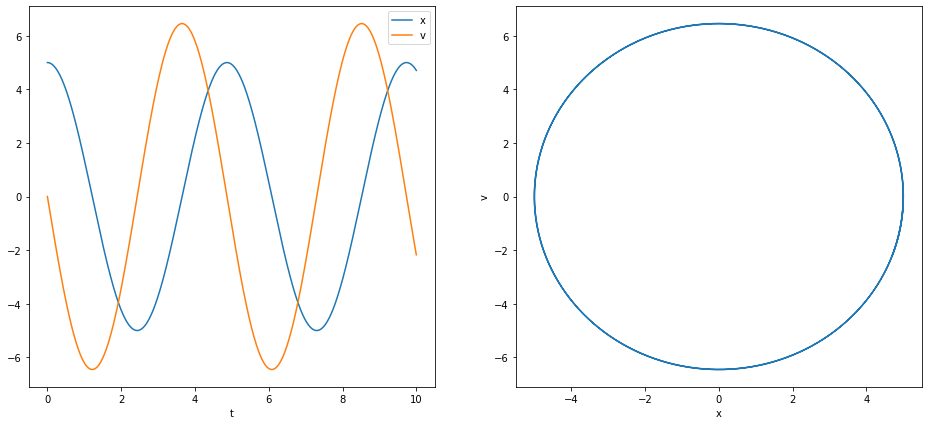

<Figure size 432x288 with 0 Axes>

In [4]:
# Prepare two side by side plots
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(16,7))

# Axis 1: Show the different state variables against time
ax1.set(xlabel="t")
ax1.plot(times, states[:,0], label="x")
ax1.plot(times, states[:,1], label="v")
ax1.legend()

# Axis 2: Show the x,y plane
ax2.set(xlabel="x", ylabel="v")
ax2.plot(states[:,0], states[:,1])

# Show and close the plot
plt.show()
plt.clf()

<hr style="height:1px;width:75%">

<p style="font-size:20px;color:Blue;">
Add a cubic perturbation to the spring force
<br><br>
    $$
    F = -kx - kx^3
    $$
<br><br>
and solve the system again.
<br><br>
$\cdot$ What differences do you see? Can you explain them? For which range of values are the results the same?
</p>

<hr style="height:1px;width:75%">

<p style="font-size:20px;color:Blue;">
Expand the system and study two masses connected by springs to eachother and the walls. The system will follow
<br><br>
    $$
    m\ddot{x}_1 = - k_1x_1 + k2(x_2 - x_1),\\
    m\ddot{x}_2 = k_2(x_1 - x_2) - k_3x_2.
    $$
<br><br>
where all symbols have conventional meanings.
<br><br>
$\cdot$ Experiment with symmetric initial conditions and asymmetric initial conditions. Consider this in terms of normal modes
</p>

<hr style="height:1px;width:75%">

<p style="font-size:20px;color:Blue;">
$\cdot$ As a bonus challenge, try solving the full forced damped oscillator and compare to analytic results.
</p>